# 10 quad optimization

Consider a beamline with 10 quarupoles separated by drifts. The initial beam profile in $x$-$y$ is elliptical and we want a round beam downstream with beamsize $\sigma_{\mathrm{target}} = 5.00~\mathrm{mm}$. Let's find the 10 quadrupole strengths such that this happens by using gradient based optimization and automatic differentiation.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
%config InlineBackend.figure_format = 'retina'

In [2]:
# Initial particle bunch

from bmadx import Particle, M_ELECTRON

s = torch.tensor(0.0) # initial s
p0c = torch.tensor(4.0E+07) # Reference particle momentum in eV
mc2 = torch.tensor(M_ELECTRON) # electron mass in eV

# Initial beam distribution
n_particles = 10000 # number of particles in beam
mean = torch.zeros(6)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 3e-6, 2e-6, 1e-6, 2e-6]))
torch.manual_seed(0)
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
coords = dist.sample(torch.Size([n_particles])) # particles' coordinates

p_in = Particle(*coords.T, s, p0c, mc2) # created Particle named tuple corresponding to the beam

Text(0, 0.5, '$y$ (mm)')

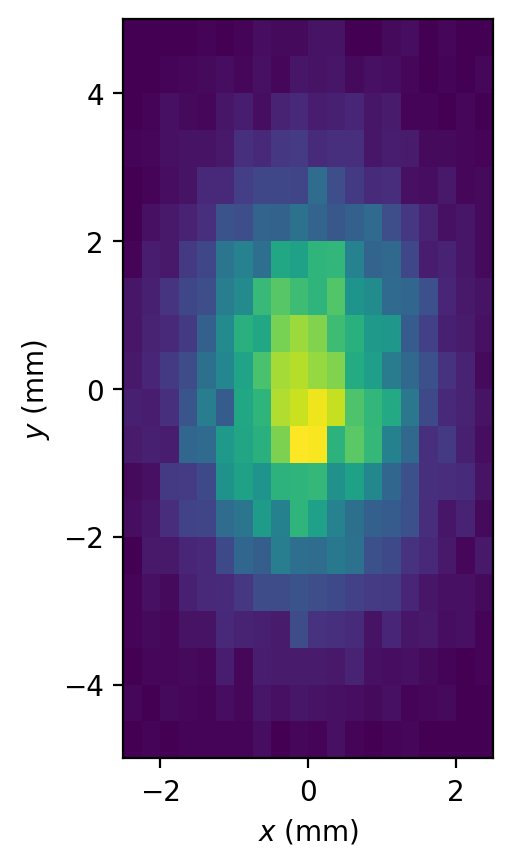

In [3]:
# plot initial beam distribution
fig, ax = plt.subplots()
ax.hist2d(p_in.x.numpy()*1e3, p_in.y.numpy()*1e3, bins=20, range=[[-2.5,2.5],[-5,5]])
ax.set_aspect('equal')
ax.set_xlabel(r'$x$ (mm)')
ax.set_ylabel(r'$y$ (mm)')

In [4]:
sigma_target = 5e-3 # target beam size

We can define the loss function as the pythagorean sum of the beamsize discrepancies in $x$ and $y$: $$L = \sqrt{\Delta_x^2+\Delta_y^2}~,$$ where $\Delta_i = \sigma_i-\sigma_{\mathrm{target}}$.

Now let's create a model of the beamline and find the set of quarupole strengths $\{k_1, ..., k_{10}\}$ that minimize $L$. 

In [5]:
# import Drift and Quadrupole elements
from bmadx import Drift, Quadrupole

# define torch presets for Quadrupole
def torchquadrupole(L: torch.Tensor, K1: torch.Tensor, NUM_STEPS=1,
                    X_OFFSET: torch.Tensor=torch.tensor(0.0),
                    Y_OFFSET: torch.Tensor=torch.tensor(0.0),
                    TILT: torch.Tensor=torch.tensor(0.0)):
    return Quadrupole(L=L, K1=K1, NUM_STEPS=NUM_STEPS, X_OFFSET=X_OFFSET,
                      Y_OFFSET=Y_OFFSET, TILT=TILT)

# create drifts:
drift = Drift(L=0.9) # each drift is 90 cm long

# import lattice tracking routine
from bmadx import track_a_lattice

In [6]:
# Model to optimize (we can inheritate from torch.nn.Module and use PyTorch optimizers)
class BeamlineModel(torch.nn.Module):
    """Beamline torch module."""
    def __init__(self, k_set):
        super().__init__()
        # register set of quad strengths as parameter:
        self.register_parameter('k_set',torch.nn.Parameter(k_set))
    def forward(self):
        # create lattice given quad strengths in k_set: 
        L_q = 0.1 # quad length 
        lattice = [drift]
        for k1 in self.k_set:
            lattice.append( torchquadrupole(L=L_q, K1=k1) )
            lattice.append( drift )
            
        # outgoing particle:
        p_out = track_a_lattice(p_in, lattice)[-1]
        
        # calculate and return loss function:
        sigma_x = torch.std(p_out.x)
        sigma_y = torch.std(p_out.y)
        dx = (sigma_x - sigma_target)
        dy = (sigma_y - sigma_target)
        return torch.sqrt(dx**2+dy**2)

In [7]:
# Training function
def train_model(model, training_iter, alpha=0.1):
    history_param = [None] * training_iter # list to save params
    history_loss = [None] * training_iter # list to save loss
    
    # print the trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')
    
    # Use PyTorch Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), alpha)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Calc loss and backprop gradients
        loss = model()  # loss is just O.F.
        loss.backward() # gradient
        
        # print info:
        if i%100==0: #print each 100 steps
            print('Iter %d/%d - Loss: %.5f '% (
                i + 1, training_iter, loss
            ))
        
        # save loss and param
        for param in model.parameters():
            history_param[i] = param.data.detach().numpy().copy()
        history_loss[i] = loss.detach().numpy().copy()
        
        # optimization step
        optimizer.step()
    
    # returns params and loss for every iteration
    return np.asarray(history_param), np.asarray(history_loss)

In [8]:
%%time
# Initial k_set
k_set = torch.zeros(10)

# Optimization
model = BeamlineModel(k_set)
params, loss = train_model(model, 500, 0.01)

k_set : Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
Iter 1/500 - Loss: 0.01487 
Iter 101/500 - Loss: 0.00551 
Iter 201/500 - Loss: 0.00087 
Iter 301/500 - Loss: 0.00006 
Iter 401/500 - Loss: 0.00002 
CPU times: user 8.08 s, sys: 2.72 s, total: 10.8 s
Wall time: 10 s


Text(0, 0.5, 'loss $\\sqrt{\\Delta_x^2 + \\Delta_y^2}$ (mm)')

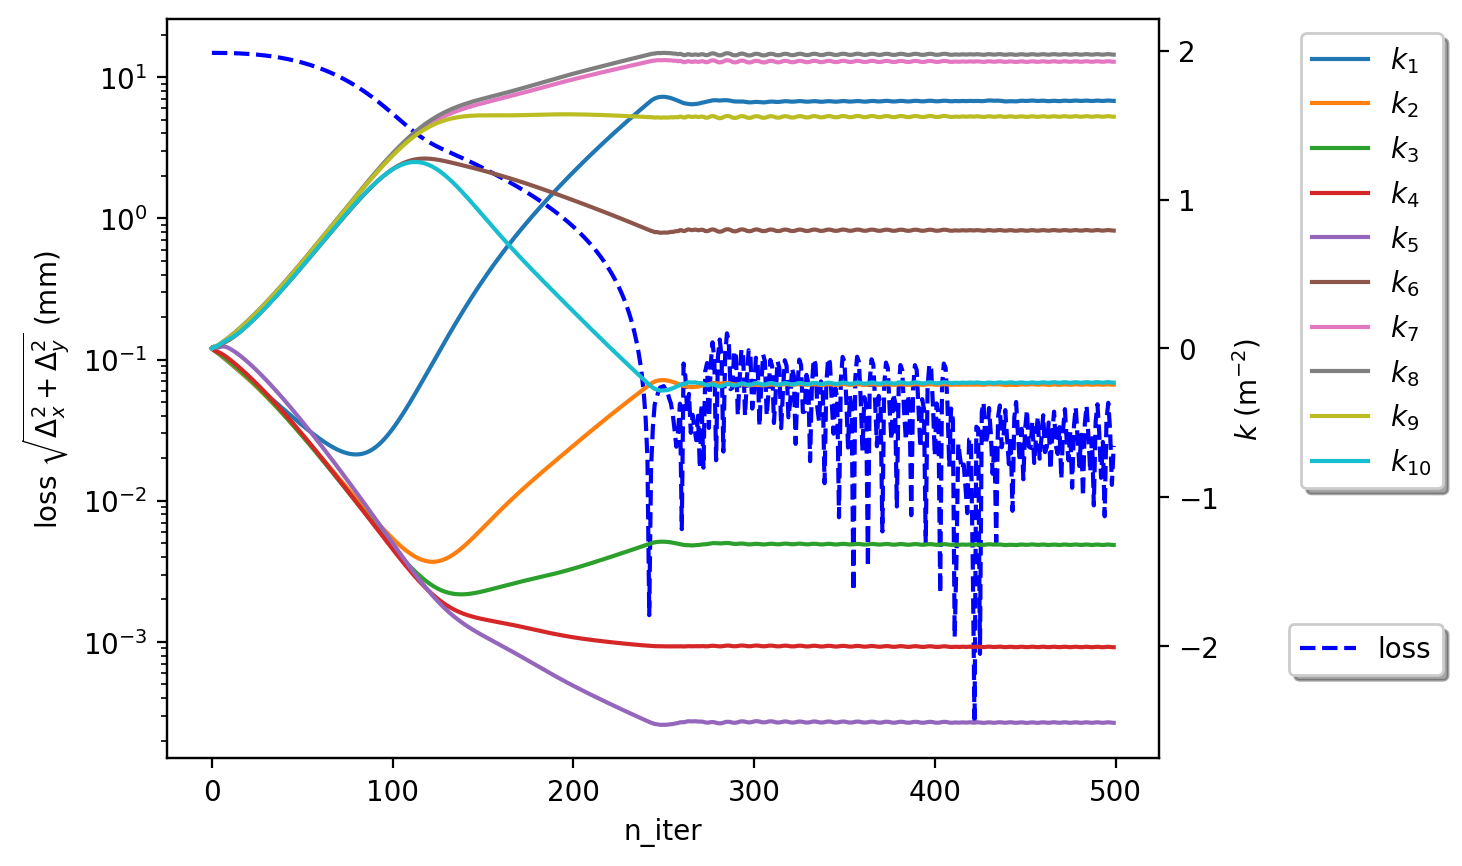

In [9]:
# Plot loss and parameters as function of iteration number
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(k_set)):
    ax2.plot(np.arange(len(params[:,0])), params[:,i], label=f'$k_{{{i+1}}}$')
ax1.plot(np.arange(len(loss)), loss*1000, '--b', label='loss')
ax1.set_yscale('log')                
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1, fancybox=True, shadow=True)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 0.2), ncol=1, fancybox=True, shadow=True)
ax1.set_xlabel('n_iter')
ax2.set_ylabel(r'$k$ (m$ ^{-2}$)')
ax1.set_ylabel(r'loss $\sqrt{\Delta_x^2 + \Delta_y^2}$ (mm)')

In [10]:
# save optimal set of quad strengths
k_opt = params[-1]
k_opt

array([ 1.6630027 , -0.24410601, -1.3209964 , -2.0081184 , -2.5160933 ,
        0.7913955 ,  1.9258957 ,  1.9737816 ,  1.5566975 , -0.23038842],
      dtype=float32)

In [12]:
# create lattice with optimal quad strengths
lattice = [drift]
L_q = 0.1 # Quad lenght
for k1 in k_opt:
    lattice.append( torchquadrupole(L=torch.tensor(L_q), K1=k1) )
    lattice.append( drift )

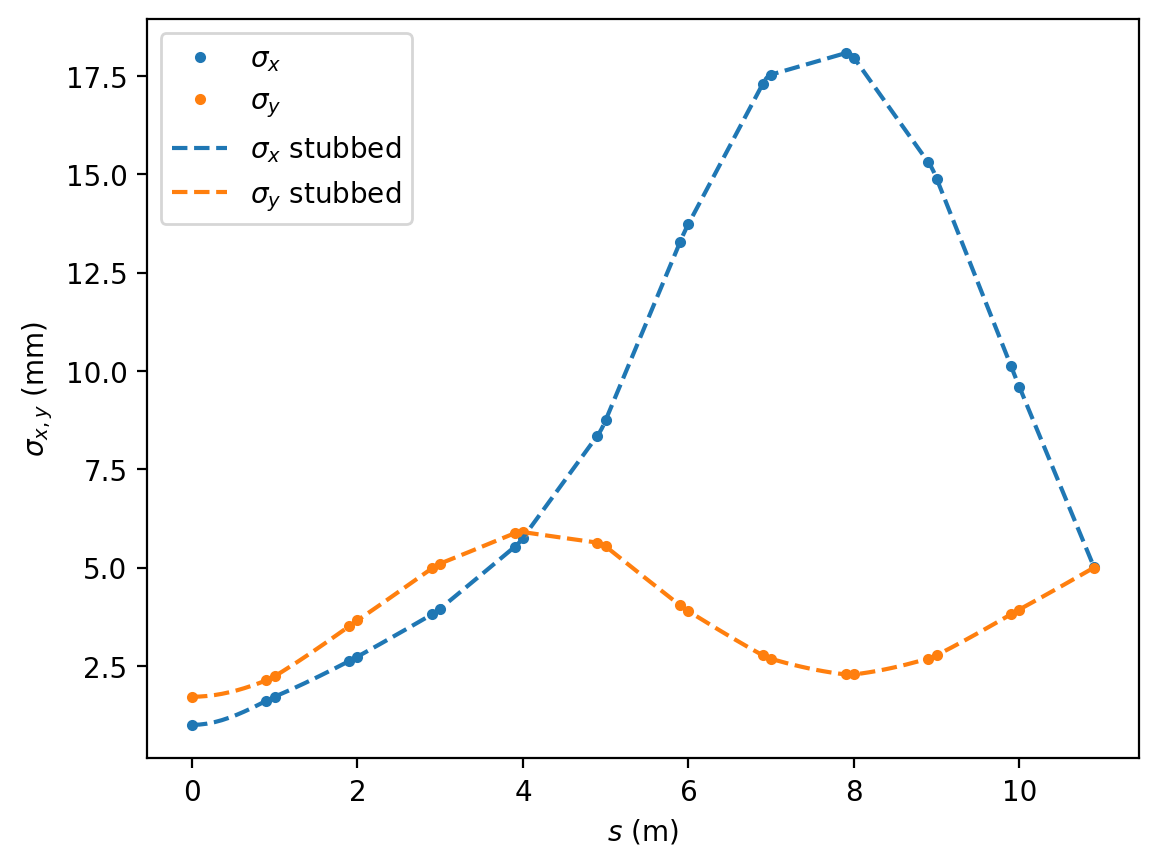

In [13]:
# plot beamsize vs s for optimal configuration
from bmadx import stub_lattice

stubbed_lattice = stub_lattice(lattice, 10) # stub lattice for plotting

all_p = track_a_lattice(p_in, lattice)
all_p_stubbed = track_a_lattice(p_in, stubbed_lattice)

stdx = np.array([torch.std(par.x).item() for par in all_p])
stdy = np.array([torch.std(par.y).item() for par in all_p])
stdx_stubbed = np.array([torch.std(par.x).item() for par in all_p_stubbed])
stdy_stubbed = np.array([torch.std(par.y).item() for par in all_p_stubbed])

s = np.array([par.s.item() for par in all_p])
s_stubbed = np.array([par.s.item() for par in all_p_stubbed])

plt.plot(s, stdx*1000, '.', color='C0', label=r'$\sigma_x$')
plt.plot(s, stdy*1000, '.', color='C1', label=r'$\sigma_y$')
plt.plot(s_stubbed, stdx_stubbed*1000, color='C0', linestyle='--', label=r'$\sigma_x$ stubbed')
plt.plot(s_stubbed, stdy_stubbed*1000, color='C1', linestyle='--',label=r'$\sigma_y$ stubbed')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()

Text(0, 0.5, '$y$ (mm)')

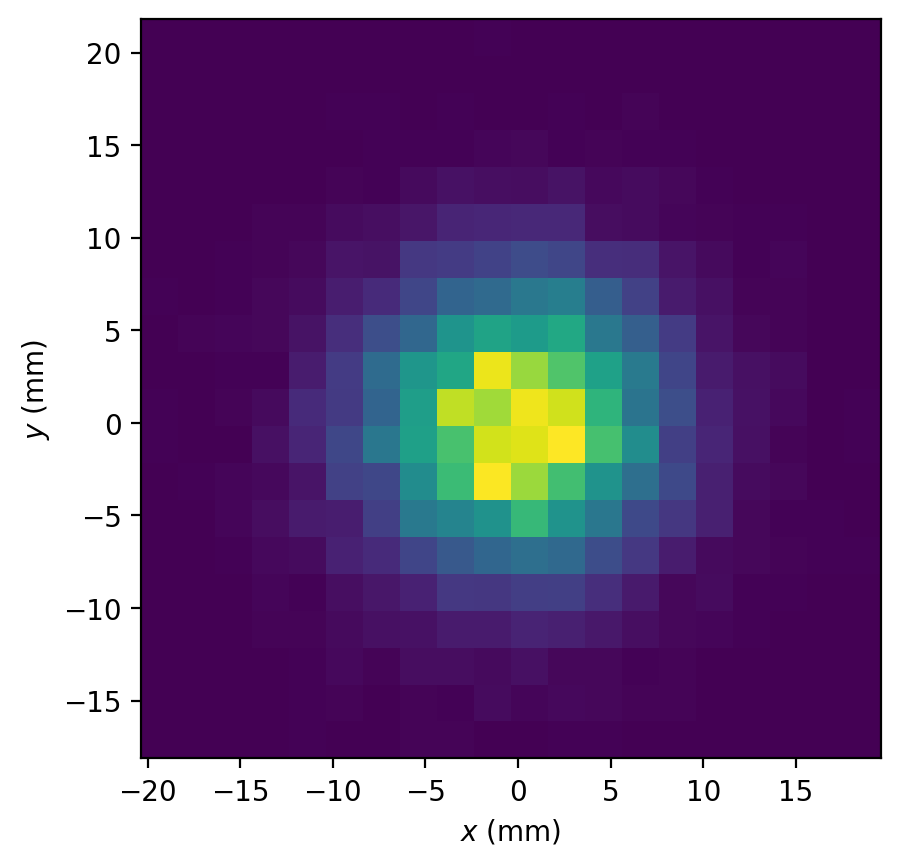

In [14]:
# plot final beam profile
fig, ax = plt.subplots()
ax.hist2d(all_p[-1].x.numpy()*1e3, all_p[-1].y.numpy()*1e3, bins=20)
ax.set_aspect('equal')
ax.set_xlabel(r'$x$ (mm)')
ax.set_ylabel(r'$y$ (mm)')